WARNING    'i' is an internal variable of group 'synapses_207', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignor

0.034356098652683076
0.05660188679433964
0.15848931924611562
0.6431000406460929
1.0


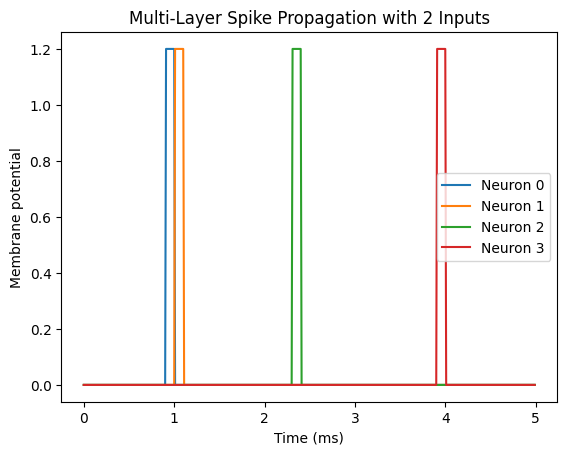

Spike times: {0: array([1.]) * msecond, 1: array([1.1]) * msecond, 2: array([2.4]) * msecond, 3: array([4.]) * msecond}


In [71]:
from brian2 import *

start_scope()

# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    
    # main block that is calcualing the sigmoid like shift then adding layer
    x = global_clock % 1
    
    if w >= 0:
        print((x ** (1 - w)))
        return (x ** (1 - w))
    else:
        print((1 - (1 - x) ** (1 + w)))
        return (1 - (1 - x) ** (1 + w))
        
    return 0
    #print(sum)
    print(spikes_received)
    return layer + (sum) # right now an average but we'll see
    

# 4 Neurons: 0 & 1 = hidden, 2 = integrator, 3 = output
neurons = NeuronGroup(4, '''
    v : 1
    sum : 1
    spikes_received : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')
neurons.v = 0
neurons.scheduled_time = 1e9 * second
neurons.global_clock = 0.0
neurons.sum = 0.0
neurons.spikes_received = 0

# Two spike inputs
stim = SpikeGeneratorGroup(2, indices=[0, 1], times=[0.1, 0.1]*ms)

# Input layer: stim[0] → neuron[0], stim[1] → neuron[1]
syn_input = Synapses(stim, neurons[0:2], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
    
''')
syn_input.connect(j='i')  # connect stim[i] to neurons[i]
syn_input.w = [-0.7, -0.5]
syn_input.layer = [1, 1]

# Hidden layer: neuron[0] & neuron[1] → neuron[2]
syn_hidden = Synapses(neurons[0:2], neurons[2], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
''')
syn_hidden.connect()
syn_hidden.w = [0.6, 0.8]
syn_hidden.layer = [2, 2]

# Output layer: neuron[2] → neuron[3]
syn_output = Synapses(neurons[2], neurons[3], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
''')
syn_output.connect()
syn_output.w = 1.0
syn_output.layer = 3

# Scheduled activation & clock update
neurons.run_regularly('''
    v = int(abs(t - scheduled_time) < 0.05*ms) * 1.2

               
    global_clock += 0.01
''', dt=0.01*ms)

# Monitors
mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
mon2 = StateMonitor(neurons, 'spikes_received', record=True, dt=0.01*ms)


spikemon = SpikeMonitor(neurons)

# Run simulation
run(5*ms)

# Plot neuron voltages
for i in range(4):
    plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane potential')
title('Multi-Layer Spike Propagation with 2 Inputs')
legend()
show()

# Print spikes
print("Spike times:", spikemon.spike_trains())
#print("# of spikes received by neuron 0:", mon2.spikes_received[0])



WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'scheduled_time = ms * spike_timing(w, global_clock, layer)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'scheduled_time = ms * spike_timing(w, global_clock, layer)'
 [brian2.codegen.generators.base]


[0.11]
- ===  [1.0343561]
[0.01]
+ ===  [2.39810717]


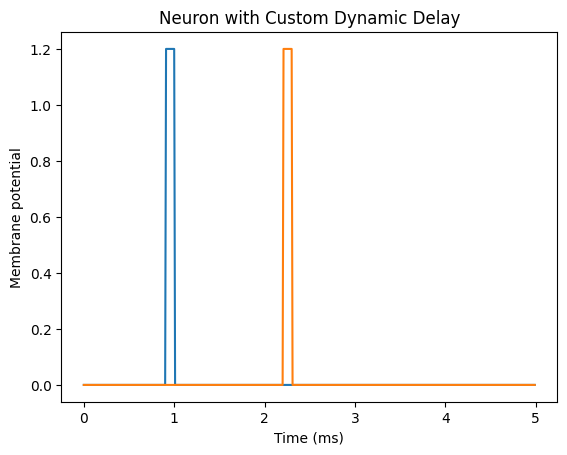

Spike times for neuron 0: {0: array([1.]) * msecond, 1: array([2.3]) * msecond}


In [23]:
# Created another Layer here so Input --> N1 --> N2

from brian2 import *

start_scope()

# can remove layer if we know all within 1ms each layer 
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1)
def spike_timing(w, global_clock, layer): 
    x = ((global_clock) % 1) 
    #layer_bias = int((t/ms)/2000)   # why by 200 not even a unit of bias ms --> mew seconds and such
    print(x)
    if not (0 <= x <= 1 and -1 <= w <= 1):
        raise ValueError("x must be in [0, 1] and w in [-1, 1]")
    if w >= 0:
        print("+ === ", layer + (x ** (1 - w)))
        return layer + (x ** (1 - w))
    else:
        print("- === ", layer + (1 - (1 - x) ** (1 + w)))
        return layer + (1 - (1 - x) ** (1 + w))
    



global_time = 0.0 # alreay to t var
input_val   = 0.1


#  ====== neuron gen here =========
neurons = NeuronGroup(2, '''
    v : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')
neurons.scheduled_time = 1e9 * second  # init with far-future
neurons.global_clock = 0.0   # will make new method but a pain to work out so useing this for now

# Spike generator
stim = SpikeGeneratorGroup(1, indices=[0], times=[input_val]*ms)




syn0 = Synapses(stim, neurons[0], '''
    w : 1
    layer : 1
''', on_pre='''
    scheduled_time = spike_timing(w, global_clock, layer) * ms
''')
syn0.connect()
syn0.w = -0.7
syn0.layer = 1

# Hidden → Output synapse
syn1 = Synapses(neurons[0], neurons[1], '''
    w : 1
    layer : 1
''', on_pre='''
    scheduled_time = spike_timing(w, global_clock, layer) * ms
''')
syn1.connect()
syn1.w = 0.8
syn1.layer = 2


# Apply effect when scheduled time arrives # the werid eq is just for rounding  if error and both 0 will it not fire?
neurons.run_regularly('''    
v = int(int(t / (0.1*ms)) == int(scheduled_time / (0.1*ms))) * 1.2
global_clock += 0.01
''', dt=0.01*ms)


# Monitor
mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
spikemon = SpikeMonitor(neurons)

run(5*ms)

# Plot
plot(mon.t/ms, mon.v[0])
plot(mon.t/ms, mon.v[1])
xlabel('Time (ms)')
ylabel('Membrane potential')
title('Neuron with Custom Dynamic Delay')
show()

# Print spike times
print("Spike times for neuron 0:", spikemon.spike_trains())
# Or equivalently:
#print("All spike times:", spikemon.t)
# print("Neuron indices:", spikemon.i)


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'scheduled_time = ms * spike_timing(w, global_clock, layer)'
 [brian2.codegen.generators.base]


[0.11]
- ===  [1.0343561]


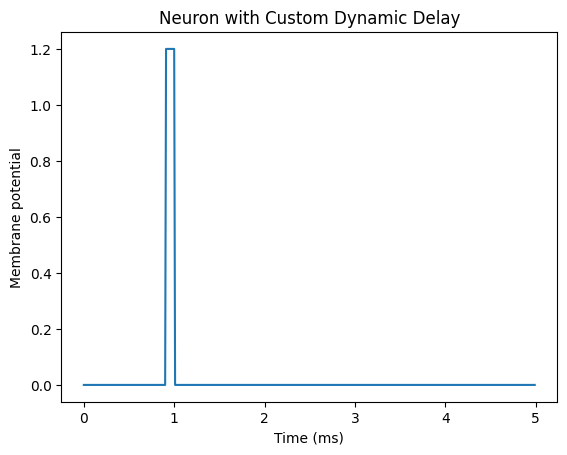

Spike times for neuron 0: [1.] ms


In [14]:
#complete 1 neuron working input to biased output
from brian2 import *

start_scope()

# can remove layer if we know all within 1ms each layer 
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1)
def spike_timing(w, global_clock, layer): 
    x = ((global_clock) % 1) 
    #layer_bias = int((t/ms)/2000)   # why by 200 not even a unit of bias ms --> mew seconds and such
    print(x)
    if not (0 <= x <= 1 and -1 <= w <= 1):
        raise ValueError("x must be in [0, 1] and w in [-1, 1]")
    if w >= 0:
        print("+ === ", layer + (x ** (1 - w)))
        return layer + (x ** (1 - w))
    else:
        print("- === ", layer + (1 - (1 - x) ** (1 + w)))
        return layer + (1 - (1 - x) ** (1 + w))
    



global_time = 0.0 # alreay to t var
input_val   = 0.1


#  ====== neuron gen here =========
neurons = NeuronGroup(1, '''
    v : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')
neurons.scheduled_time = 1e9 * second  # init with far-future
neurons.global_clock = 0.0   # will make new method but a pain to work out so useing this for now

# Spike generator
stim = SpikeGeneratorGroup(1, indices=[0], times=[input_val]*ms)




# Synapse
syn = Synapses(stim, neurons,
               '''
               w : 1
               layer : 1
               ''',
               on_pre='''
               scheduled_time = spike_timing(w, global_clock, layer) * ms
               ''')

syn.connect()
syn.w = -0.7
syn.layer = 1


# Apply effect when scheduled time arrives # the werid eq is just for rounding  if error and both 0 will it not fire?
neurons.run_regularly('''    
v = int(int(t / (0.1*ms)) == int(scheduled_time / (0.1*ms))) * 1.2
global_clock += 0.01
''', dt=0.01*ms)


# Monitor
mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
spikemon = SpikeMonitor(neurons)

run(5*ms)

# Plot
plot(mon.t/ms, mon.v[0])
xlabel('Time (ms)')
ylabel('Membrane potential')
title('Neuron with Custom Dynamic Delay')
show()

# Print spike times
print("Spike times for neuron 0:", spikemon.spike_trains()[0])
# Or equivalently:
#print("All spike times:", spikemon.t)
# print("Neuron indices:", spikemon.i)


In [27]:

time = 2.7

k = time % 1  # will give you

j = int(time)


print(k)

print(j)

0.7000000000000002
2
